Class weights: {0: 0.6059160305343512, 1: 2.8603603603603602}
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 582ms/step - accuracy: 0.5271 - auc: 0.5861 - loss: 0.8434 - val_accuracy: 0.8208 - val_auc: 0.6183 - val_loss: 0.5491 - learning_rate: 1.0000e-04
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.5382 - auc: 0.6047 - loss: 0.8151 - val_accuracy: 0.1792 - val_auc: 0.6435 - val_loss: 3.5081 - learning_rate: 1.0000e-04
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.5897 - auc: 0.6790 - loss: 0.6714 - val_accuracy: 0.1792 - val_auc: 0.5392 - val_loss: 4.0178 - learning_rate: 1.0000e-04
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - accuracy: 0.5442 - auc: 0.5375 - loss: 0.7911 - val_accuracy: 0.1792 - val_auc: 0.5000 - val_loss: 9.1960 - learning_rate: 1.0000e-04
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.5989 - auc: 0.6323 - loss: 0.6852 - val_accuracy: 0.3255 - val_auc: 0.6496 - val_loss: 0.9818 - learning_rate: 1.0000e-04
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.57

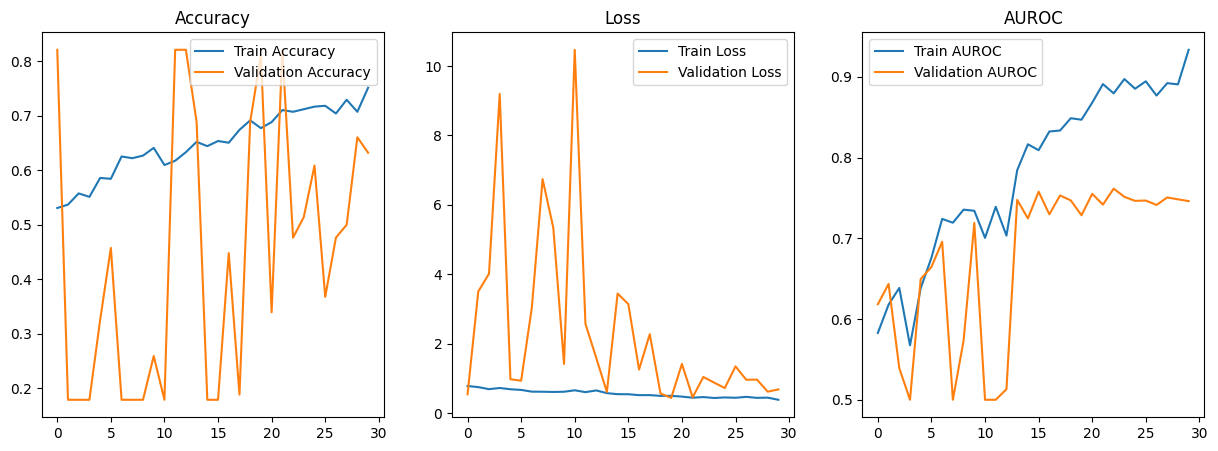

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.3765 - auc: 0.6457 - loss: 1.1709
Test Loss: 1.0316, Test Accuracy: 0.4744, Test AUROC: 0.8547
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Optimal Threshold: 0.8146


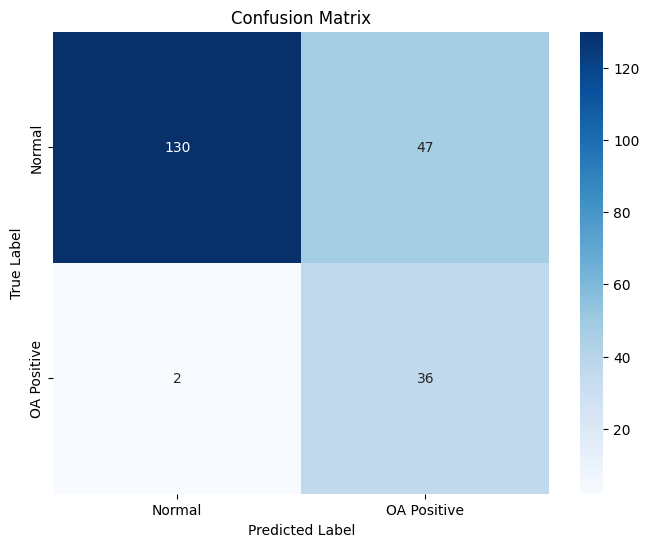

Confusion Matrix:
 [[130  47]
 [  2  36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.73      0.84       177
           1       0.43      0.95      0.60        38

    accuracy                           0.77       215
   macro avg       0.71      0.84      0.72       215
weighted avg       0.89      0.77      0.80       215



In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 피클 파일 로드
with open('/content/drive/MyDrive/TMJ OA/기존 MRI1,2 + NEW MRI1,2/tmj_oa_MRI1,2+NEW_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

# 데이터셋 분리
train_images = dataset['train_data']['image']
train_labels = dataset['train_data']['label']
val_images = dataset['validation_data']['image']
val_labels = dataset['validation_data']['label']
test_images = dataset['test_data']['image']
test_labels = dataset['test_data']['label']

# 데이터 증강 생성기 설정
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# 데이터 증강 생성기를 통해 데이터 생성
train_generator = train_datagen.flow(
    train_images, train_labels, batch_size=32, shuffle=True
)

val_generator = val_datagen.flow(
    val_images, val_labels, batch_size=32, shuffle=False
)

test_generator = test_datagen.flow(
    test_images, test_labels, batch_size=32, shuffle=False
)

# VGG16 모델 구성
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(140, 140, 3))
for layer in base_model.layers[:-12]:
    layer.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# 클래스 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
#class_weights = {0: 1.0, 1: 1.5}  # 클래스 1에 더 높은 가중치 부여
print("Class weights:", class_weights)

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_auc', patience=7, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg16_auroc.keras', save_best_only=True, monitor='val_auc', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, mode='max', min_lr=1e-6)

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# 학습 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUROC')
plt.plot(history.history['val_auc'], label='Validation AUROC')
plt.legend()
plt.title('AUROC')
plt.show()

# 테스트 데이터 평가
test_loss, test_accuracy, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUROC: {test_auc:.4f}")

# ROC Curve
y_pred = model.predict(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Confusion Matrix
y_pred_adjusted = (y_pred >= optimal_threshold).astype(int)
#y_pred_adjusted = (y_pred >= 0.4).astype(int)  # 임계값을 약간 높임
conf_matrix = confusion_matrix(test_labels, y_pred_adjusted)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "OA Positive"], yticklabels=["Normal", "OA Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, y_pred_adjusted))

model.save('/content/drive/MyDrive/TMJ OA/기존 MRI1,2 + NEW MRI1,2/NEW MRI1,2_model.keras')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
AUC: 0.8550
95% CI: 0.7918 - 0.9083


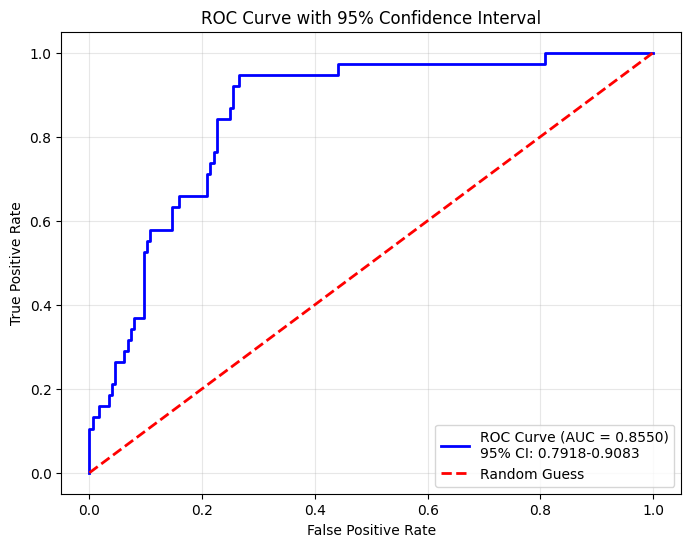

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 테스트 레이블 및 예측값
y_true = test_labels  # 실제 레이블
y_pred = model.predict(test_images / 255.0).flatten()  # 예측 확률값 (스케일링된 이미지 사용)

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# AUC 95% CI 계산 (부트스트랩)
n_bootstraps = 1000  # 부트스트랩 샘플 수
rng = np.random.RandomState(42)  # 재현성 확보
bootstrapped_aucs = []

for i in range(n_bootstraps):
    # 부트스트랩 샘플링
    indices = rng.choice(len(y_true), len(y_true), replace=True)
    y_true_bootstrap = y_true[indices]
    y_pred_bootstrap = y_pred[indices]

    try:
        auc_bootstrap = roc_auc_score(y_true_bootstrap, y_pred_bootstrap)
        bootstrapped_aucs.append(auc_bootstrap)
    except ValueError:  # 예외 처리 (불가능한 경우 스킵)
        continue

# 신뢰 구간 계산
lower = np.percentile(bootstrapped_aucs, 2.5)
upper = np.percentile(bootstrapped_aucs, 97.5)

print(f"AUC: {roc_auc:.4f}")
print(f"95% CI: {lower:.4f} - {upper:.4f}")

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})\n95% CI: {lower:.4f}-{upper:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')

# 그래프 스타일 설정
plt.title('ROC Curve with 95% Confidence Interval')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()